In [1]:
from eda import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    Input,
    Flatten,
    GlobalMaxPooling1D,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import shuffle
import random
import os
seed = 777
# Set the seed for random number generation in Python
random.seed(seed)

# Set the seed for NumPy
np.random.seed(seed)

# Set the seed for TensorFlow
tf.random.set_seed(seed)

# Force TensorFlow to use deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2024-10-30 00:28:31.936211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 00:28:32.065947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 00:28:32.105256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 00:28:32.352609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 00:28:34.873316: W tensorflow/compiler/tf2

In [2]:
file_path = './data_preprocessing/binary_classification'

all_files = glob.glob(os.path.join(file_path, '*.csv'))

# Initialize lists to hold individual train and test DataFrames
test_list = []
train_list = []
# Loop over all files and read them
for filename in all_files:
    # Extract hotel name from filename
    hotel_name = os.path.basename(filename).replace('_input_data.csv', '')  # Removes directory and specific file extension
    temp_df = pd.read_csv(filename)
    temp_df['hotel'] = hotel_name  # Add a column for hotel name
    
    # Perform train-test split for each hotel's data
    train_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['label'], random_state=42)
    
    # Append the resulting DataFrames to the lists
    train_list.append(train_df)
    test_list.append(test_df)

# Concatenate all test DataFrames into one for final test data
test_data = pd.concat(test_list, ignore_index=True)
train_data = pd.concat(train_list, ignore_index=True)
# Shuffle the combined train and test data
train_data = shuffle(train_data, random_state=42)
test_data = shuffle(test_data, random_state=42)
# Concatenate all DataFrames into one
data = pd.read_csv('./data_preprocessing/kaggle/input_data.csv')
data['label'] = data['label'].apply(lambda x: 1 if x > 0.5 else 0)
# Combine df_test to data
data = pd.concat([data, train_data], ignore_index=True)
# Shuffle the combined DataFrame
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)


label
1    21402
0     3749
Name: count, dtype: int64


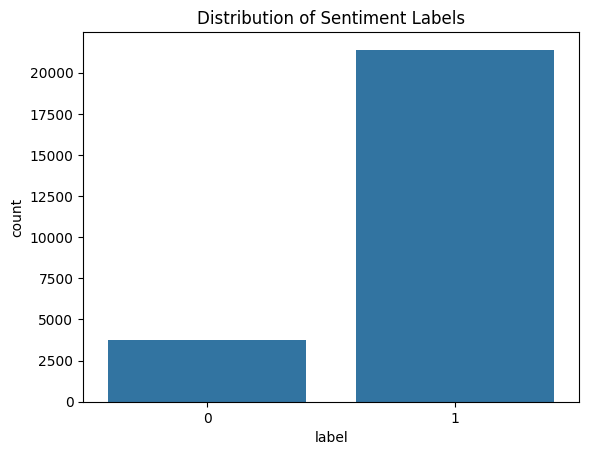

In [3]:
print(data['label'].value_counts())
# Distribution of labels
sns.countplot(x='label', data=data)
plt.title('Distribution of Sentiment Labels')
plt.show()

In [4]:
# Features and labels
X_train = data[['cleaned_content', 'Review Content', 'normalized_score']]
y_train = data['label']
X_test = test_data[['cleaned_content', 'Review Content', 'normalized_score']]
y_test = test_data['label']

# Reset index after splitting
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Perform the split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Reset index after splitting
X_train = X_train.reset_index(drop=True)
X_val = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_test.reset_index(drop=True)

# Display the distribution of labels in training and testing sets
print("Training label distribution:\n", y_train.value_counts())
print("\nTesting label distribution:\n", y_test.value_counts())
print("\nValidation label distribution:\n", y_val.value_counts())


Training label distribution:
 label
1    17121
0     2999
Name: count, dtype: int64

Testing label distribution:
 label
1    1782
0     231
Name: count, dtype: int64

Validation label distribution:
 label
1    1782
0     231
Name: count, dtype: int64


In [5]:
# Check for empty strings or strings that only contain spaces in 'cleaned_content' column
empty_or_space_strings = X_train['cleaned_content'].apply(lambda x: x.strip() == '')

# Get the indices of such rows
indices = empty_or_space_strings[empty_or_space_strings].index

# Print the indices and the corresponding rows
print(f"Indices of rows with empty or space-only strings: {indices.tolist()}")
print(X_train.loc[indices])

Indices of rows with empty or space-only strings: []
Empty DataFrame
Columns: [cleaned_content, Review Content, normalized_score]
Index: []


count    20120.000000
mean        86.259344
std         90.109764
min          8.000000
25%         35.000000
50%         62.000000
75%        104.000000
max       1861.000000
Name: cleaned_content, dtype: float64


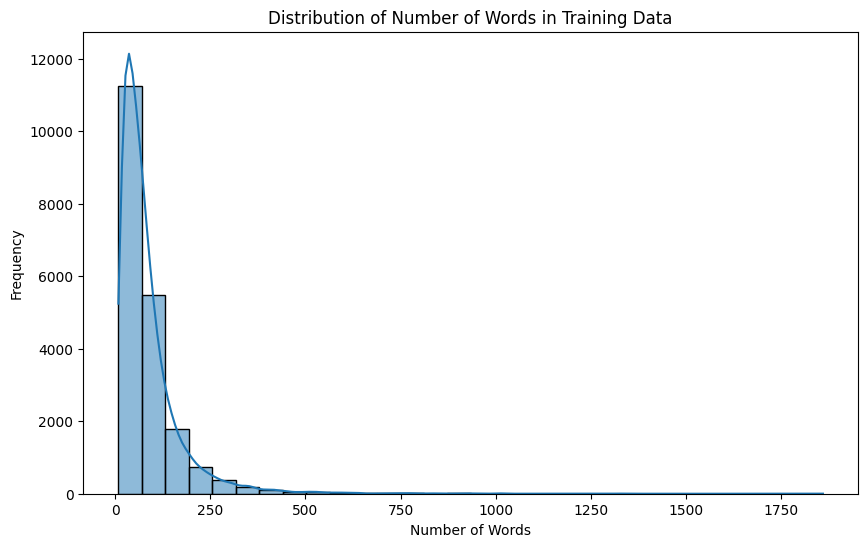

In [6]:
# Calculate the number of words in each review in the training data
word_counts = X_train['cleaned_content'].apply(lambda x: len(x.split()))
# Display basic statistics
print(word_counts.describe())

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=30, kde=True)
plt.title('Distribution of Number of Words in Training Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [7]:
def preprocess_text(texts, tokenizer, max_sequence_length = 100):
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences to the same length
    sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return sequences_padded

In [8]:

from keras.preprocessing.sequence import pad_sequences

# Combine training and testing texts for fitting the tokenizer
texts = X_train['cleaned_content']

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Calculate the median length of the words in X_train['cleaned_content']
word_lengths = X_train['cleaned_content'].apply(lambda x: len(x.split()))
max_sequence_length = int(np.mean(word_lengths))
print(f"Max sequence length: {max_sequence_length}")

X_train_padded = preprocess_text(X_train['cleaned_content'], tokenizer, max_sequence_length)
X_test_padded = preprocess_text(X_test['cleaned_content'], tokenizer, max_sequence_length)
X_val_padded = preprocess_text(X_val['cleaned_content'], tokenizer, max_sequence_length)

print(len(X_train_padded), len(X_test_padded), len(X_val_padded))

Max sequence length: 86
20120 2013 2013


In [9]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Prepare sentences for Word2Vec
sentences = [text.split() for text in texts]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=max_sequence_length, window=5, min_count=1, workers=4)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_dim = max_sequence_length
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=True
))
# Add a convolutional layer followed by max pooling
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                 kernel_regularizer=l2(0.0001)
                 ))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False, 
                            kernel_regularizer=l2(0.0001), 
                            dropout=0.3
                            )))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1730219331.991816   32872 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730219332.394484   32872 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730219332.394596   32872 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730219332.401633   32872 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730219332.401779   32872 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_padded,
    y_train,
    epochs=15,
    batch_size=300,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping]
)   


Epoch 1/15


2024-10-30 00:29:01.038558: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730219341.334362   33115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730219343.691019   33115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730219343.793620   33115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7738 - loss: 0.5819

W0000 00:00:1730219347.010960   33115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730219347.053218   33113 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730219347.055694   33113 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.7746 - loss: 0.5809 - val_accuracy: 0.8852 - val_loss: 0.3867
Epoch 2/15
 1/68 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8433 - loss: 0.4574

W0000 00:00:1730219347.760363   33115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8517 - loss: 0.4352 - val_accuracy: 0.8852 - val_loss: 0.3588
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8517 - loss: 0.4060 - val_accuracy: 0.8852 - val_loss: 0.3324
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8564 - loss: 0.3639 - val_accuracy: 0.8907 - val_loss: 0.3055
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8674 - loss: 0.3299 - val_accuracy: 0.8867 - val_loss: 0.2881
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8844 - loss: 0.3047 - val_accuracy: 0.8783 - val_loss: 0.3010
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8860 - loss: 0.2945 - val_accuracy: 0.8798 - val_loss: 0.2961
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8898 - loss: 0.2855 - val_accuracy: 0.8793 - val_loss: 0.2892
Epoch 9/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8909 - loss: 0.2829 - val_accuracy: 0.8887 - val_loss: 0.

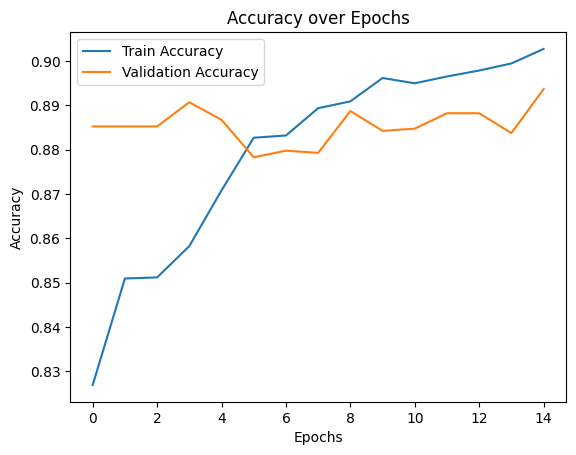

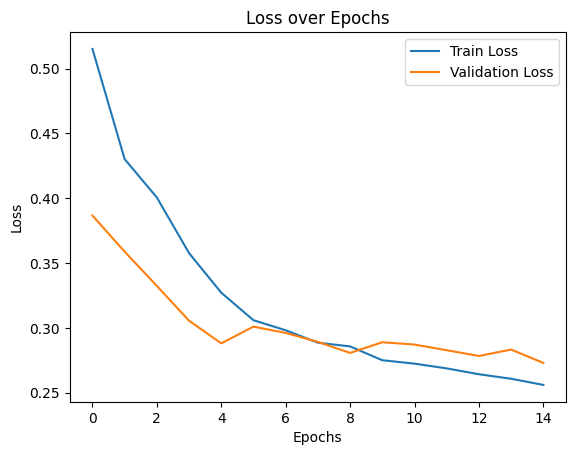

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Predict on test data
y_pred_prob = model.predict(X_test_padded)



15/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

W0000 00:00:1730219391.608390   33115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


W0000 00:00:1730219392.804877   33111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


In [15]:
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.55      0.50      0.52       231
    Positive       0.94      0.95      0.94      1782

    accuracy                           0.89      2013
   macro avg       0.74      0.72      0.73      2013
weighted avg       0.89      0.89      0.89      2013



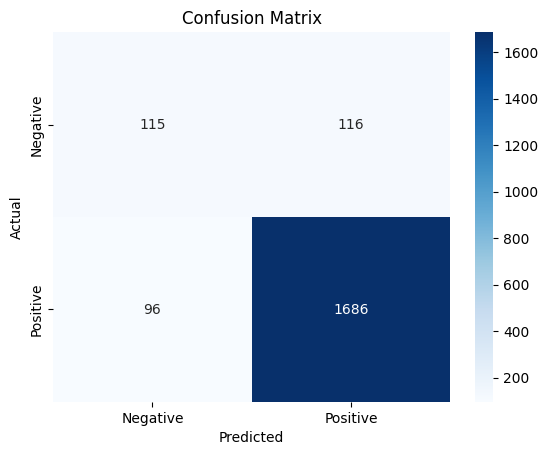

[[ 115  116]
 [  96 1686]]


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(cm)

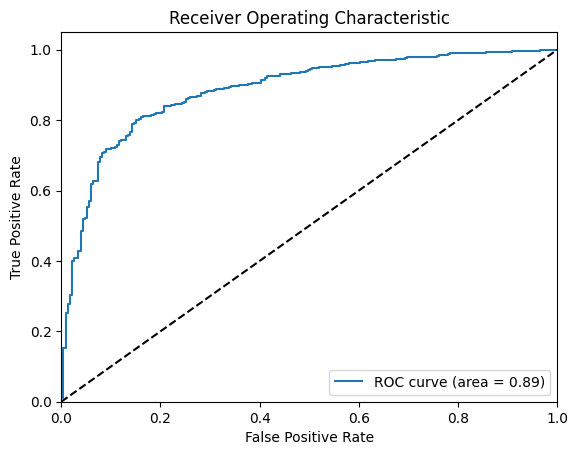

ROC-AUC Score: 0.8852157943067034


In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Score:", roc_auc)


                                       mean
hotel                                      
bai_hotel                          0.912090
dusit_thani_mactan                 0.885804
fairfield_by_marriott_cebu         0.880212
jpark_island_resort_and_waterpark  0.821256
seda_ayala_center_cebu             0.891007
waterfront_hotel_and_casino        0.756936


/tmp/ipykernel_32872/3414647754.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)


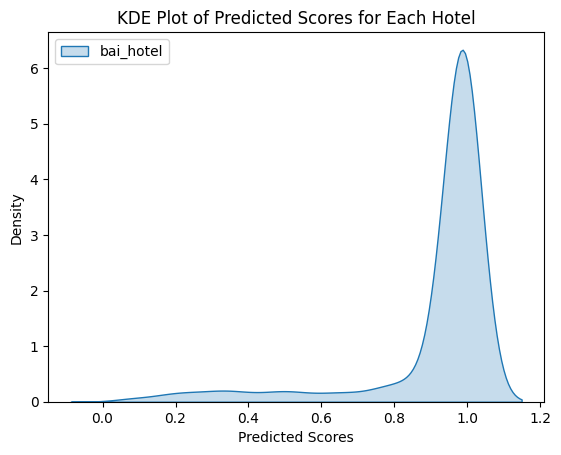

/tmp/ipykernel_32872/3414647754.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)


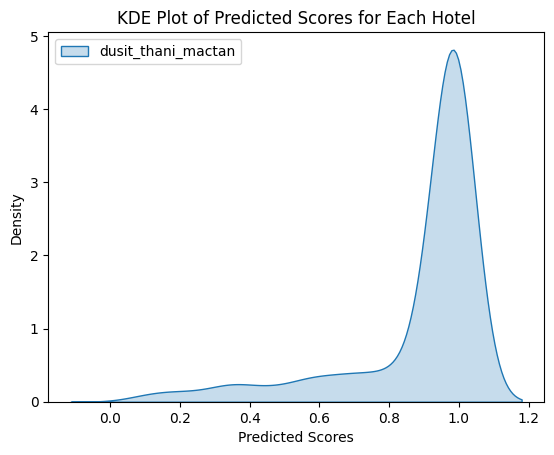

/tmp/ipykernel_32872/3414647754.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)


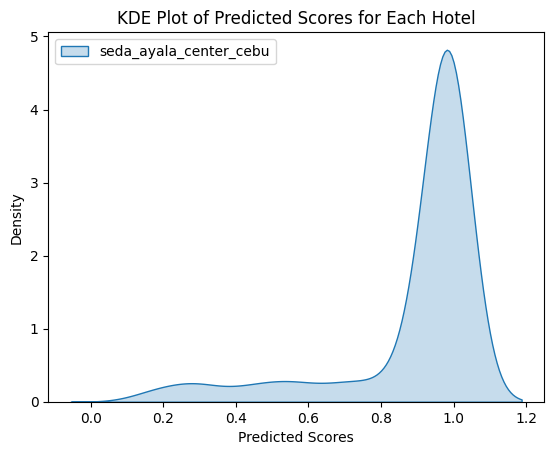

/tmp/ipykernel_32872/3414647754.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)


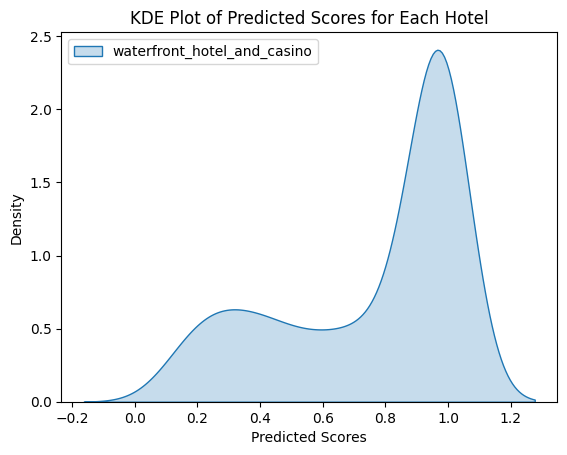

/tmp/ipykernel_32872/3414647754.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)


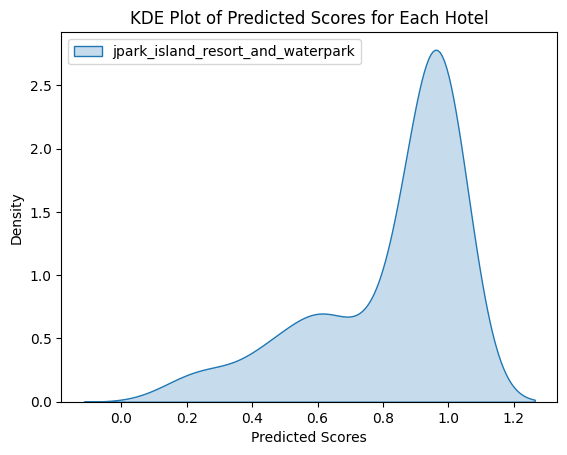

/tmp/ipykernel_32872/3414647754.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)


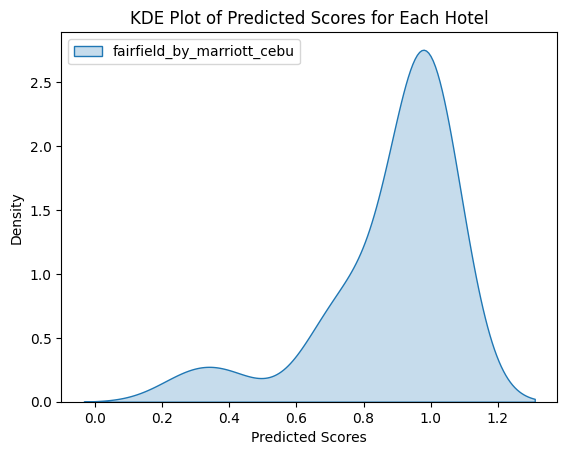

In [18]:
# Add the predicted probabilities to the scraped_data DataFrame
test_data['predicted_scores'] = y_pred_prob

# Calculate the range of predicted scores per hotel
score_ranges = test_data.groupby('hotel')['predicted_scores'].agg(['mean'])
print(score_ranges)
# KDE plot for each hotel
# plt.figure(figsize=(12, 8))

for hotel in test_data['hotel'].unique():
    sns.kdeplot(test_data[test_data['hotel'] == hotel]['predicted_scores'], label=hotel, shade=True)
    plt.title('KDE Plot of Predicted Scores for Each Hotel')
    plt.xlabel('Predicted Scores')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


# Save the predicted probabilities to CSV files per hotel
# for hotel in test_data['hotel'].unique():
#     hotel_data = test_data[test_data['hotel'] == hotel]
#     hotel_data.to_csv(f'./predicted/{hotel}_predicted_prob.csv', index=False)